$$
\newcommand{\bx}{\boldsymbol{x}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\btheta}{\boldsymbol{\theta}}
$$

# Ordinal regression from scratch

In an ordinal regression model to the outcome has $K$ ordered possible outcomes: $y \in [1,\dots,K]$, with a cumulative density function defined for eack level:

$$
\begin{align*}
P(y \leq k; \bx,\bbeta,\btheta  ) &= F(\theta_k - \bx^T \bbeta) \hspace{2mm} \longleftrightarrow \\
P(y = k ; \bx,\bbeta,\btheta) &= F(\theta_k - \bx^T \bbeta) - F(\theta_{k-1} - \bx^T \bbeta)
\end{align*}
$$

Different choices of $F$ are possible for the link function including the standard normal CDF, but throughout this post we will use the sigmoid function: $F(z) = \sigma(z) = 1/(1+\exp(-z))$. Note that $\sigma'(z) = \sigma(z)(1-\sigma(z))$. The "threshold" approach refers to the $K+1$ threshold of $[\theta_0,\theta_1,\dots,\theta_K]$, where $\theta_{k-1} < \theta_{k}$, $\forall k$. The bottom and top thresholds are fixed so that the CDF is bounded between $(0,1)$: $(\theta_0,\theta_K) = (-\infty,\infty)$ . Therefore $\btheta$ refers to the $K-1$ estimable thresholds. When these parameters are estimated the inequality constraints must be preserved. Notice that each "level" of $y$ shares the same slope coefficients: $\bbeta$, it is only in the intercepts that they differ. In contrast to multinomial logistic regression where each $K-1$ class needs its own intercept and slope. This need is obviated due to the ordinal nature of the class and the assumption that the log-odds (when $F$ is the sigmoid anyways) changes in equal measure across all ordinal categories. For example if $\beta_1=2$, then a one-unit change in $x_1$ increases the log-odds that $y > 2, \dots, y>K-1$ by two.


 The log-likelihood and its gradient for $n$ samples can be written as:

$$
\begin{align*}
\log L(\bbeta) &= l(\bbeta;\btheta) = \sum_{i=1}^n I(y_i=k) \log  \big[ \sigma(\theta_k - \eta_i) - \sigma(\theta_{k-1} - \eta_i) \big] \\
\eta_i &= \bx_i^T \bbeta \\
\frac{\partial l(\bbeta;\btheta)}{\partial \bbeta} &= \nabla_\bbeta = -\sum_{i=1}^n \bx_i I(y_i = k) \Bigg( \frac{\sigma'(\theta_k-\eta_i) + \sigma'(\theta_{k-1}-\eta_i)}{d_{ik}} \Bigg) \\
d_{ik} &= \sigma(\theta_k-\eta_i) - \sigma(\theta_{k-1}-\eta_i) \\
\frac{\partial l(\bbeta;\btheta)}{\partial \btheta} &= \nabla_\btheta = \sum_{i=1}^n \Bigg( I(y_i = k) \frac{\sigma'(\theta_k-\eta_i)}{d_{ik}} - I(y_i = k+1) \frac{\sigma'(\theta_k-\eta_i)}{d_{ik+1}} \Bigg)
\end{align*}
$$

In order to avoid having to do constrained optimization, it will be easier to reparametrize $\btheta=f(\balpha)$ as: $\theta_k = \alpha_1 + \sum_{j=2}^k e^{\alpha_j}$, where $\alpha_1=\theta_1$. The gradient for the intercepts is the same as before along with the chain rule:

$$
\begin{align*}
\frac{\partial l(\bbeta;\balpha)}{\partial \balpha} &= \nabla_\balpha = \begin{pmatrix} 1 \\ e^{\alpha_2} \\ \vdots \\ e^{\alpha_K} \end{pmatrix}  \nabla_\btheta
\end{align*}
$$


As the likelihood and gradients show, it is useful to save the indices of which rows correspond to which ordinal levels for faster computation. After the model has been fit, a new sample $\tilde \bx$, can be evaluated by calculating:

$$
\begin{align*}
\tilde y &= \arg\max_k [P(y=k|\bbeta;\btheta;\tilde\bx)] \\
P(y=k|\bbeta;\btheta;\tilde\bx)  &= \begin{cases}
1 - \sigma(\theta_{K-1}-\tilde\eta) & \text{ if } k=K \\
\sigma(\theta_{K-1}-\tilde\eta) - \sigma(\theta_{K-2}-\tilde\eta) & \text{ if } k=K-1 \\
\vdots & \vdots \\
\sigma'(\theta_{1}-\tilde\eta) - 0 & \text{ if } k=1
\end{cases}
\end{align*}
$$

The code block below creates the necessary functions to calculate the loss, gradients, and probabilities for an ordinal model. The `ordinal_reg` wrapper will allow us to fit an ordinal regression model for $p$-dimensional data and $K$ level classes. 

In [0]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

def sig1(z): # sigma
    return(1/(1+np.exp(-z)))
def sig2(z): # sigma'(z)
    phat = sig1(z)
    return(phat*(1-phat))

class y2ord(): # Convert ordinal to 1, 2, ... K
    def __init__(self):
        self.di = {}
    def fit(self,y):
        self.uy = np.sort(np.unique(y))
        self.di = dict(zip(self.uy, np.arange(len(self.uy))+1))
    def transform(self,y):
        return(np.array([self.di[z] for z in y]))

def alpha2theta(alpha,K): # theta[t] = theta[t-1] + exp(alpha[t])
    return(np.cumsum(np.append(alpha[0], np.exp(alpha[1:]))))

def theta2alpha(theta,K): # alpha[t] = log(theta[t] - theta[t-1])
    return(np.append(theta[0],np.log(theta[1:] - theta[:-1])))

def alpha_beta_wrapper(alpha_beta, X, lb=20, ub=20):
    K = len(alpha_beta) + 1
    if X is not None:
        K -= X.shape[1]
        beta = alpha_beta[K - 1:]
    else:
        beta = np.array([0])
    alpha = alpha_beta[:K - 1]
    theta = alpha2theta(alpha, K)
    theta = np.append(np.append(theta[0] - lb, theta), theta[-1] + ub)
    return(alpha, theta, beta, K)

# Likelihood function
def nll_ordinal(alpha_beta, X, idx_y, lb=20, ub=20):
    alpha, theta, beta, K = alpha_beta_wrapper(alpha_beta, X, lb, ub)
    score = np.dot(X,beta)
    ll = 0
    for kk, idx in enumerate(idx_y):
        ll += sum(np.log(sig1(theta[kk+1]-score[idx])-sig1(theta[kk]-score[idx])))
    nll = -1*(ll / X.shape[0])
    return(nll)

# Gradient wrapper
def gll_ordinal(alpha_beta, X, idx_y, lb=20, ub=20):
    grad_alpha = gll_alpha(alpha_beta, X, idx_y)
    grad_X = gll_beta(alpha_beta, X, idx_y)
    return(np.append(grad_alpha,grad_X))

# gradient function for beta
def gll_beta(alpha_beta, X, idx_y, lb=20, ub=20):
    alpha, theta, beta, K = alpha_beta_wrapper(alpha_beta, X, lb, ub)
    score = np.dot(X, beta)
    grad_X = np.zeros(X.shape[1])
    for kk, idx in enumerate(idx_y):  # kk = 0; idx=idx_y[kk]
        den = sig1(theta[kk + 1] - score[idx]) - sig1(theta[kk] - score[idx])
        num = -sig2(theta[kk + 1] - score[idx]) + sig2(theta[kk] - score[idx])
        grad_X += np.dot(X[idx].T, num / den)
    grad_X = -1 * grad_X / X.shape[0]  # negative average of gradient
    return(grad_X)

# gradient function for theta=exp(alpha)
def gll_alpha(alpha_beta, X, idx_y, lb=20, ub=20):
    alpha, theta, beta, K = alpha_beta_wrapper(alpha_beta, X, lb, ub)
    score = np.dot(X, beta)
    grad_alpha = np.zeros(K - 1)
    for kk in range(K-1):
        idx_p, idx_n = idx_y[kk], idx_y[kk+1]
        den_p = sig1(theta[kk + 1] - score[idx_p]) - sig1(theta[kk] - score[idx_p])
        den_n = sig1(theta[kk + 2] - score[idx_n]) - sig1(theta[kk+1] - score[idx_n])
        num_p, num_n = sig2(theta[kk + 1] - score[idx_p]), sig2(theta[kk + 1] - score[idx_n])
        grad_alpha[kk] += sum(num_p/den_p) - sum(num_n/den_n)
    grad_alpha = -1* grad_alpha / X.shape[0]  # negative average of gradient
    grad_alpha *= np.append(1, np.exp(alpha[1:])) # apply chain rule
    return(grad_alpha)

# inference probabilities
def prob_ordinal(alpha_beta, X, lb=20, ub=20):
    alpha, theta, beta, K = alpha_beta_wrapper(alpha_beta, X, lb, ub)
    score = np.dot(X, beta)
    phat = (np.atleast_2d(theta) - np.atleast_2d(score).T)
    phat = sig1(phat[:, 1:]) - sig1(phat[:, :-1])
    return(phat)

# Wrapper for training/prediction
class ordinal_reg():
    def __init__(self,standardize=True):
        self.standardize = standardize
    def fit(self,data,lbls):
        self.p = data.shape[1]
        self.Xenc = StandardScaler().fit(data)
        self.yenc = y2ord()
        self.yenc.fit(y=lbls)
        ytil = self.yenc.transform(lbls)
        idx_y = [np.where(ytil == yy)[0] for yy in list(self.yenc.di.values())]
        self.K = len(idx_y)
        theta_init = np.array([(z + 1) / self.K for z in range(self.K - 1)])
        theta_init = np.log(theta_init / (1 - theta_init))
        alpha_init = theta2alpha(theta_init, self.K)
        param_init = np.append(alpha_init, np.repeat(0, self.p))
        self.alpha_beta = minimize(fun=nll_ordinal, x0=param_init, method='L-BFGS-B', jac=gll_ordinal,
                                   args=(self.Xenc.transform(data), idx_y)).x
    def predict(self,data):
        phat = prob_ordinal(self.alpha_beta,self.Xenc.transform(data))
        return(np.argmax(phat,axis=1)+1)
    def predict_proba(self,data):
        phat = prob_ordinal(self.alpha_beta,self.Xenc.transform(data))
        return(phat)

## Univariate example

Words

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors

n = 50
np.random.seed(1234)
mus_1d = np.arange(-2,2+1,2)
df_1d = pd.concat([pd.DataFrame({'x':0.75*np.random.randn(25)+mu,'mu':mu})
                                    for mu in mus_1d]).reset_index(drop=True)
di_mu_1d = dict(zip(mus_1d,['lvls'+str(x+1) for x in range(len(mus_1d))]))
df_1d['lvl'] = df_1d.mu.map(di_mu_1d)
# Fit model
mdl_1d = ordinal_reg()
mdl_1d.fit(df_1d[['x']],df_1d.mu)

# Calculate accuracy
df_1d_prob = pd.DataFrame(mdl_1d.predict_proba(df_1d[['x']]),columns=list(di_mu_1d.values()))
df_1d_prob = df_1d_prob.assign(x=df_1d.x).melt('x',var_name='lvl',value_name='prob')
df_1d_acc = pd.crosstab(index=df_1d.lvl,columns=mdl_1d.predict(df_1d[['x']]))
df_1d_acc.index.name='Actual'
df_1d_acc.columns.name='Predicted'
print(df_1d_acc)

Predicted   1   2   3
Actual               
lvls1      24   1   0
lvls2       2  22   1
lvls3       0   3  22


Accuracy is good

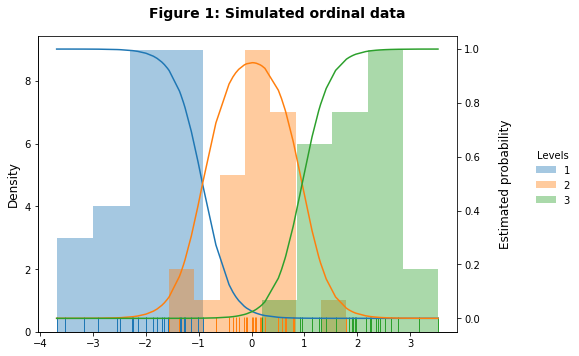

In [11]:
# Function to map prob over histogram
def dens_mapper(*args ,**kwargs):
    ax = plt.gca()
    frame = kwargs.pop('data')
    sns.distplot(a=frame['x'].values, hist=True, kde=False, rug=True, ax=ax, **kwargs)
    if frame.lvl.unique()=='lvls'+str(len(mus_1d)):
        ax2 = ax.twinx()
        sns.lineplot(data=df_1d_prob, x='x', y='prob',hue='lvl', legend=False, ax=ax2, **kwargs)
        ax2.set_ylabel('Estimated probability',size=12)
        ax2.yaxis.set_label_coords(1.1, 0.5)

g_1d = sns.FacetGrid(df_1d.sort_values('lvl'),hue='lvl',height=5,aspect=1.5,sharey=False)
g_1d.map_dataframe(dens_mapper)
g_1d.add_legend()
g_1d.fig.suptitle('Figure 1: Simulated ordinal data',size=14,weight='bold')
g_1d._legend.set_title('Levels')
g_1d.fig.subplots_adjust(top=0.9,right=0.8,left=0.1)
[z.set_text(t) for z,t in zip(g_1d._legend.texts,
                pd.Series(list(di_mu_1d.values())).astype(str).str.replace('lvls',''))]
g_1d.set_ylabels('Density',size=12)

## 2-D example

words

Predicted   1   2   3   4
Actual                   
lvls1      46   4   0   0
lvls2       1  41   8   0
lvls3       0   7  37   6
lvls4       0   0   7  43


Text(0.5, 0.98, 'Figure 2: Simulated 2D ordinal data')

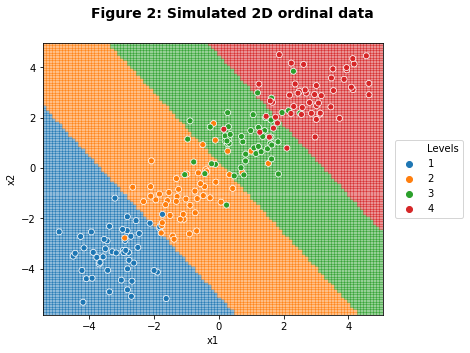

In [12]:
np.random.seed(1234)
cov = np.array([[1,0.5],[0.5,1]])
mus_2d = np.arange(-3,3+1,2)
df_2d = pd.concat([pd.DataFrame(np.random.multivariate_normal(np.array([mu,mu]),cov,n),
                                columns={'x1','x2'}).assign(mu=mu) for mu in mus_2d])
di_mu_2d = dict(zip(mus_2d,['lvls'+str(x+1) for x in range(len(mus_2d))]))
df_2d['lvl'] = df_2d.mu.map(di_mu_2d)
# Fit model
mdl_2d = ordinal_reg()
mdl_2d.fit(df_2d[['x1','x2']],df_2d.mu)
# Get accuracy
df_2d_acc = pd.crosstab(index=df_2d.lvl,columns=mdl_2d.predict(df_2d[['x1','x2']]))
df_2d_acc.index.name='Actual'
df_2d_acc.columns.name='Predicted'
print(df_2d_acc)
# Plot decision boundaries
x1, x2 = np.meshgrid(np.arange(df_2d.x1.min()-0.5, df_2d.x1.max()+0.5,0.1),
            np.arange(df_2d.x2.min()-0.5, df_2d.x2.max()+0.5,0.1))
yhat_2d = mdl_2d.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)


fig, ax = plt.subplots(1, figsize=(7, 5))
plt.pcolormesh(x1, x2, yhat_2d, cmap=colors.ListedColormap(sns.color_palette(n_colors=4)), alpha=0.5)
sns.scatterplot('x1','x2','lvl',data=df_2d, ax=ax)
fig.axes[0].legend(loc='right',bbox_to_anchor=(1.25,0.5))
fig.subplots_adjust(right=0.8)
[z.set_text(t) for z,t in zip(fig.axes[0].legend_.texts[1:],
                pd.Series(list(di_mu_2d.values())).astype(str).str.replace('lvls',''))]
fig.axes[0].legend_.get_texts()[0].set_text('Levels')
fig.suptitle('Figure 2: Simulated 2D ordinal data',size=14,weight='bold')


## Applied example for housing quantiles

Words